## ALUMNO: JOSE  DE JESUS HERRERA LEDON
## PERCEPCION COMPUTACIONAL
## GRUPO 9


### Anomalia: Sal y pimienta (generado)
#### Se utilzaran dos imagenes a color a las que se les generara artificailmente una anomalia aleatoria de puntos negros y blancos, despues se utilizata una tecnica de HIstograma para recuperar en medida de lo posigle la imagen original. 

####  Este proyecot incluye un archivo requiremets.txt  y un README relacionados con las dependencias y la ejecucion del documento

In [17]:
# python librearies
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray, array, copy, uint8

RGB


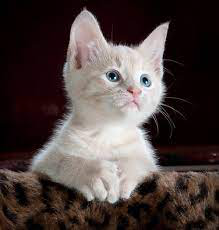

In [22]:
image_easy_colors = Image.open('gato_blanco.jpeg', mode='r', formats=['jpeg'])
image_easy_array = asarray(image_easy_colors)
image_grey_cat =  Image.open('gato_gris.jpeg')
image_grey_cat_array = asarray(image_grey_cat)
print(image_easy_colors.mode)
image_easy_colors

RGB


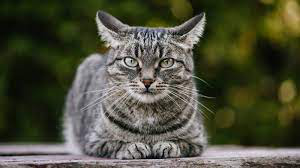

In [25]:
print(image_grey_cat.mode)
image_grey_cat

### Antes de agregar el ruidoa  a la imagen es necesario mapear la imagen en un vector representativo a la imagen


#### Las imagenes estan seleccionadas en formato jpeg RGB, el trabajo con png y la libreria de Pillow para retornar las imagenes no funciono correctamente

#### El formato RGB mapea cada pizel en un grupo de 3 valores, Rojo, Verde y Azu de 0 a 255 en cada uno de ellos.

#### Un pixel negro se representa como [0, 0, 0] y un pixel blanco con [255, 255, 255], conforme al modelo RGB (sistema de color aditivo)

### Veamos que pasa si cambiamos la mitad de la imagen a pixeles negros


Rows : 167
Columns: 299


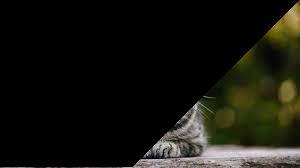

In [61]:
black_pixel = array([0,0,0])
white_pixel = array([255, 255, 255])
half_black = copy(image_grey_cat_array)
rows = len(half_black)-1
columns = len(half_black[0])-1
print("Rows : {}".format(rows))
print("Columns: {}".format(columns))
row = 0
while row < rows:
    for column in range(columns):
        #print(f"modifing {row} {column}")
        half_black[row, column] = black_pixel
    columns = columns - 1 
    row = row + 1

# print(half_black[rows])
_ = Image.fromarray(half_black)
_